数据集shape: (2000, 512)


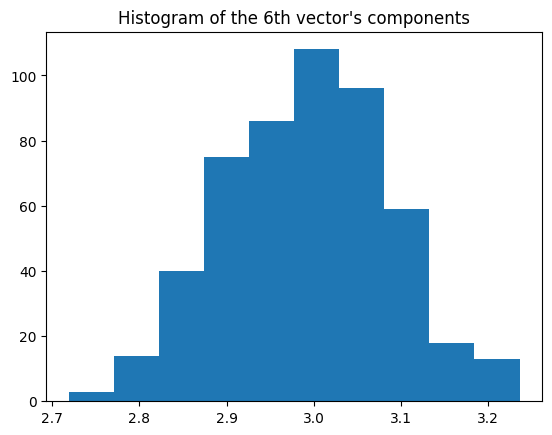

索引是否需要训练： True
索引中向量总数： 2000
距离矩阵形状: (5, 10)
索引矩阵形状: (5, 10)
距离结果（升序）：
 [[0.        8.007045  8.313328  8.53525   8.560175  8.561642  8.6241665
  8.628233  8.709977  8.77004  ]
 [0.        8.278089  8.355578  8.42606   8.462016  8.468869  8.487028
  8.549964  8.562824  8.599199 ]
 [0.        8.152369  8.156568  8.223303  8.276016  8.376868  8.379269
  8.406122  8.418619  8.443282 ]
 [0.        8.260519  8.336826  8.3393    8.402878  8.46439   8.474663
  8.479042  8.485247  8.5266   ]
 [0.        8.346273  8.407202  8.462828  8.497231  8.5208    8.597084
  8.600385  8.605133  8.630592 ]]
对应索引结果：
 [[   0  798  879  223  981 1401 1458 1174  919   26]
 [   1  981 1524 1639 1949 1472 1162  923  840  300]
 [   2 1886  375 1351  518 1735 1551 1958  390 1695]
 [   3 1459  331  389  655 1943 1483 1723 1672 1859]
 [   4   13  715 1470  608  459  888  850 1080 1654]]
倒排索引是否训练： False
倒排索引训练后是否训练： True


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import faiss

# ---------------------------
# 1. 生成符合正态分布的向量数据集
# ---------------------------
d = 512          # 向量维度
n_data = 2000    # 向量数量

np.random.seed(0)  # 固定随机种子，保证结果可复现

mu = 3           # 正态分布均值
sigma = 0.1      # 正态分布标准差

data = []
for i in range(n_data):
    # 生成一个512维符合正态分布的向量
    data.append(np.random.normal(mu, sigma, d))

data = np.array(data).astype('float32')  # 转为float32类型，符合Faiss要求

print("数据集shape:", data.shape)  # (2000, 512)

# 查看第6个向量的分布情况，确认正态分布特征
plt.hist(data[5])
plt.title("Histogram of the 6th vector's components")
plt.show()


# ---------------------------
# 2. 生成查询向量（同样符合正态分布）
# ---------------------------
n_query = 10
np.random.seed(12)  # 不同种子生成不同查询集

query = []
for i in range(n_query):
    query.append(np.random.normal(mu, sigma, d))
query = np.array(query).astype('float32')


# ---------------------------
# 3. 精确索引（IndexFlatL2）
# ---------------------------
index = faiss.IndexFlatL2(d)  # 使用L2距离的精确索引

print("索引是否需要训练：", index.is_trained)  # False，IndexFlatL2不需要训练

index.add(data)  # 添加数据到索引

print("索引中向量总数：", index.ntotal)  # 应为2000

# 用前5个数据向量自己作为查询，测试查询效果
k = 10  # 返回top 10结果
query_self = data[:5]
distances, indices = index.search(query_self, k)

print("距离矩阵形状:", distances.shape)  # (5, 10)
print("索引矩阵形状:", indices.shape)    # (5, 10)
print("距离结果（升序）：\n", distances)
print("对应索引结果：\n", indices)


# ---------------------------
# 4. 倒排索引快速查找（IndexIVFFlat）
# ---------------------------
nlist = 50  # 将数据库划分成50个簇（维诺空间数量）
quantizer = faiss.IndexFlatL2(d)  # 量化器（粗聚类器）

# 构建倒排索引，采用L2距离度量
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)

print("倒排索引是否训练：", index.is_trained)  # False，需要训练

index.train(data)  # 训练倒排索引，训练集应和数据集分布一致

print("倒排索引训练后是否训练：", index.is_trained)  # True

index.add(data)    # 添加数据

index.nprobe = 50  # 查询时扫描50个簇，数值越大召回越全但越慢

distances, indices = index.search(query_self, k)

print("倒排索引查询距离：\n", distances)
print("倒排索引查询索引：\n", indices)


# ---------------------------
# 5. 乘积量化索引（IndexIVFPQ）
# ---------------------------
m = 8  # PQ子空间个数，必须能整除向量维度512

index = faiss.IndexIVFPQ(quantizer, d, nlist, m, 8)  # 8位编码

index.train(data)  # PQ需要训练聚类+子量化中心

index.add(data)

index.nprobe = 50  # 查询时扫描的簇数

distances, indices = index.search(query_self, k)  # 查询自己，测试效果

print("乘积量化索引查询距离：\n", distances)
print("乘积量化索引查询索引：\n", indices)

"""
# 如果需要使用真实查询向量，取消下面注释：
# distances, indices = index.search(query, k)  
# print(distances)
# print(indices)
"""